In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
from collections import Counter

data_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'

class_counts = {}

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)
    if os.path.isdir(class_folder):
        num_images = len(os.listdir(class_folder))
        class_counts[class_name] = num_images

total_images = sum(class_counts.values())

class_proportions = {class_name: count / total_images for class_name, count in class_counts.items()}

print("Class Proportions:")
for class_name, proportion in class_proportions.items():
    print(f"{class_name}: {proportion:.2f}")
print(total_images)


Class Proportions:
tomato_fully_ripened: 0.01
tomato_half_ripened: 0.01
banana_overripe: 0.21
banana_rotten: 0.30
banana_unripe: 0.21
banana_ripe: 0.22
tomato_green: 0.05
7395


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#resizing
IMG_SIZE = (224, 224)
#scaling and splits
data = ImageDataGenerator(rescale=1./255, validation_split=0.2)#stratified splits for unbalanced data

trainData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/train/train',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='sparse',#uses label encoding
    shuffle=True,
    subset='training'
)

valData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/train/train',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='sparse',
    shuffle=False,
    subset='validation'
)

testData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/test',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


2025-05-15 15:03:25.885348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747321406.069318      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747321406.123221      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5917 images belonging to 7 classes.
Found 1478 images belonging to 7 classes.
Found 2484 images belonging to 1 classes.


In [4]:
import os

train_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'

class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = count



for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

total = sum(class_counts.values())
print(f"\nTotal images: {total}")


tomato_fully_ripened: 55 images
tomato_half_ripened: 90 images
banana_overripe: 1550 images
banana_rotten: 2207 images
banana_unripe: 1522 images
banana_ripe: 1600 images
tomato_green: 371 images

Total images: 7395


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

def augment_and_save_class_images(data_dir, class_name, output_dir, target_size=(256, 256), augment_factor=5):
   
    # Input and output paths
    input_class_dir = os.path.join(data_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)  # Create output dir

    # Get all image files
    image_files = [f for f in os.listdir(input_class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Data augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Process each image
    for idx, img_file in enumerate(image_files):
        # Load original image
        img_path = os.path.join(input_class_dir, img_file)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        
        # Save original (with new name to avoid conflicts)
        original_output_path = os.path.join(output_class_dir, f"orig_{idx}_{img_file}")
        save_img(original_output_path, img_array)
        
        # Generate augmented versions
        img_batch = np.expand_dims(img_array, axis=0)
        aug_generator = datagen.flow(img_batch, batch_size=1)
        
        for aug_idx in range(augment_factor):
            aug_img = next(aug_generator)[0].astype('uint8')
            aug_output_path = os.path.join(output_class_dir, f"aug_{idx}_{aug_idx}_{img_file}")
            save_img(aug_output_path, aug_img)

    print(f"Saved {len(image_files)} originals + {len(image_files)*augment_factor} augmented images to {output_class_dir}")

# Example usage
data_dir = "/kaggle/input/fine-grained-fruit-quality-assessment/train/train"
output_dir = "/kaggle/working/augmented_data"  # Writable location in Kaggle



augment_and_save_class_images(data_dir, "tomato_fully_ripened", output_dir,augment_factor=30)
augment_and_save_class_images(data_dir, "tomato_green", output_dir,augment_factor=3)
augment_and_save_class_images(data_dir, "tomato_half_ripened", output_dir,augment_factor=12)


# Verify output
print("\nOutput structure:")
!ls -lh {output_dir}/*
#banana 1600-2000

In [ ]:
import os
import shutil
from tqdm import tqdm

def combine_datasets(original_root, augmented_root, output_dir):

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Process original data - ONLY BANANA CLASSES
    print("Copying original BANANA data...")
    for class_name in tqdm(os.listdir(original_root)):
        if class_name.startswith('banana_'):  # Only process banana classes
            src_dir = os.path.join(original_root, class_name)
            dst_dir = os.path.join(output_dir, class_name)
            
            if os.path.isdir(src_dir):
                shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)
    
    # Process augmented data - ALL CLASSES (including tomatoes)
    print("Merging augmented data...")
    for class_name in tqdm(os.listdir(augmented_root)):
        src_dir = os.path.join(augmented_root, class_name)
        dst_dir = os.path.join(output_dir, class_name)
        
        if os.path.isdir(src_dir):
            os.makedirs(dst_dir, exist_ok=True)
            for file in os.listdir(src_dir):
                src_file = os.path.join(src_dir, file)
                dst_file = os.path.join(dst_dir, file)
                shutil.copy2(src_file, dst_file)

# Paths
original_data = "/kaggle/input/fine-grained-fruit-quality-assessment/train/train"
augmented_data = "/kaggle/working/augmented_data"
combined_data = "/kaggle/working/combined_data"

# Run the combination
combine_datasets(original_data, augmented_data, combined_data)

# Verification
print("\nFinal dataset structure:")
!ls -lh {combined_data}/*
print("\nFile counts:")
!find {combined_data} -type f | cut -d/ -f4 | sort | uniq -c

In [7]:
# Run this in a notebook cell
#!rm -rf /kaggle/working/combined_data

In [8]:
import os

train_dir = '/kaggle/working/augmented_data'

class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = count



for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

total = sum(class_counts.values())
print(f"\nTotal images: {total}")


tomato_fully_ripened: 1705 images
tomato_green: 1484 images
tomato_half_ripened: 1170 images

Total images: 4359


In [9]:
import os

train_dir = '/kaggle/working/combined_data'

class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = count



for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

total = sum(class_counts.values())
print(f"\nTotal images: {total}")



banana_unripe: 1522 images
banana_overripe: 1550 images
banana_ripe: 1600 images
tomato_fully_ripened: 1705 images
banana_rotten: 2207 images
tomato_green: 1484 images
tomato_half_ripened: 1170 images

Total images: 11238


**MODEL**

In [10]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Name:", tf.test.gpu_device_name())

Num GPUs Available: 1
GPU Name: /device:GPU:0


I0000 00:00:1747321566.206296      31 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Enable mixed precision for faster training
mixed_precision.set_global_policy('mixed_float16')

Bottleneck Block

In [12]:
# from tensorflow.keras import layers, Model

# def bottleneck_block(x, filters, stride=1, downsample=False):
#     shortcut = x

#     x = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     x = layers.Conv2D(filters * 4, (1, 1), strides=1, padding='same')(x)
#     x = layers.BatchNormalization()(x)

#     if downsample or shortcut.shape[-1] != filters * 4:
#         shortcut = layers.Conv2D(filters * 4, (1, 1), strides=stride, padding='same')(shortcut)
#         shortcut = layers.BatchNormalization()(shortcut)

#     x = layers.Add()([x, shortcut])
#     x = layers.ReLU()(x)
#     return x


Block Stack Function

In [13]:
# def make_layer(x, filters, blocks, stride=1):
#     x = bottleneck_block(x, filters, stride, downsample=True)
#     for _ in range(1, blocks):
#         x = bottleneck_block(x, filters)
#     return x


Full ResNet-50 Model

In [14]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, regularizers

# def build_resnet50(input_shape=(224, 224, 3), num_classes=7):
#     inputs = tf.keras.Input(shape=input_shape)

#     # Initial Conv Layer
#     x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(0.001))(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

#     # Residual Block Function
#     def residual_block(x, filters, downsample=False):
#         shortcut = x
#         strides = (2, 2) if downsample else (1, 1)

#         x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.ReLU()(x)

#         x = layers.Conv2D(filters, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
#         x = layers.BatchNormalization()(x)

#         if downsample:
#             shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)

#         x = layers.add([x, shortcut])
#         x = layers.ReLU()(x)
#         return x

#     # Stack of Residual Blocks
#     x = residual_block(x, 64)
#     x = residual_block(x, 128, downsample=True)
#     x = residual_block(x, 256, downsample=True)
#     x = residual_block(x, 512, downsample=True)

#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dropout(0.5)(x)  # Dropout added here
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     model = models.Model(inputs, outputs)
#     return model


In [15]:
# model = build_resnet50(input_shape=(224, 224, 3), num_classes=trainData.num_classes)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()


In [16]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [17]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7  # banana_overripe, banana_ripe, banana_rotten, banana_unripe, tomato_fully_ripened, tomato_green, tomato_half_ripened
EPOCHS = 50

# Enhanced data augmentation to improve generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Only rescale validation data
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Test data generator - using just rescaling for test data as in your original code
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate training data
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/combined_data',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    subset='training'
)

# Generate validation data
val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/combined_data',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    subset='validation'
)

# Generate test data - using the same path you had in your original code
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Change to None if test folders aren't organized by class
    shuffle=False
)

# Calculate class weights to handle imbalance
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Found 8992 images belonging to 7 classes.
Found 2246 images belonging to 7 classes.
Found 2484 images belonging to 1 classes.
Class weights: {0: 1.0359447004608295, 1: 1.0035714285714286, 2: 0.7273903899045462, 3: 1.0546563452967395, 4: 0.941767909509845, 5: 1.0812890812890812, 6: 1.3724053724053724}


In [18]:
def build_resnet50_custom(input_shape=(224, 224, 3), num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Conv + MaxPool
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', name='conv1_conv',
                      kernel_regularizer=regularizers.l2(0.0005))(inputs)
    x = layers.BatchNormalization(axis=3, name='conv1_bn')(x)
    x = layers.ReLU(name='conv1_relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same', name='pool1_pool')(x)

    # Bottleneck Block
    def bottleneck_block(x, filters, stage, block, downsample=False):
        filters1, filters2, filters3 = filters, filters, filters * 4
        conv_base = f'conv{stage}_block{block}'

        strides = 2 if downsample else 1

        shortcut = x

        x = layers.Conv2D(filters1, (1, 1), strides=strides, name=f'{conv_base}_1_conv',
                          kernel_regularizer=regularizers.l2(0.0005))(x)
        x = layers.BatchNormalization(axis=3, name=f'{conv_base}_1_bn')(x)
        x = layers.ReLU(name=f'{conv_base}_1_relu')(x)

        x = layers.Conv2D(filters2, (3, 3), padding='same', name=f'{conv_base}_2_conv',
                          kernel_regularizer=regularizers.l2(0.0005))(x)
        x = layers.BatchNormalization(axis=3, name=f'{conv_base}_2_bn')(x)
        x = layers.ReLU(name=f'{conv_base}_2_relu')(x)

        x = layers.Conv2D(filters3, (1, 1), name=f'{conv_base}_3_conv',
                          kernel_regularizer=regularizers.l2(0.0005))(x)
        x = layers.BatchNormalization(axis=3, name=f'{conv_base}_3_bn')(x)

        if downsample or shortcut.shape[-1] != filters3:
            shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                                     name=f'{conv_base}_0_conv',
                                     kernel_regularizer=regularizers.l2(0.0005))(shortcut)
            shortcut = layers.BatchNormalization(axis=3, name=f'{conv_base}_0_bn')(shortcut)

        x = layers.add([x, shortcut], name=f'{conv_base}_add')
        x = layers.ReLU(name=f'{conv_base}_out')(x)
        return x

    # ResNet-50 block configuration: [3, 4, 6, 3]
    block_config = [3, 4, 6, 3]
    filters = [64, 128, 256, 512]
    block_id = 1

    for stage, reps in enumerate(block_config, start=2):
        for b in range(reps):
            x = bottleneck_block(x, filters[stage - 2], stage, block_id, downsample=(b == 0))
            block_id += 1

    # Final layers
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu', name='fc1',
                     kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = models.Model(inputs, outputs, name='CustomResNet50')
    return model


In [19]:
# Build both models
custom_model = build_resnet50_custom()
keras_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Transfer matching weights
matched, unmatched = 0, 0
for layer in custom_model.layers:
    if layer.name in [l.name for l in keras_model.layers]:
        try:
            keras_weights = keras_model.get_layer(layer.name).get_weights()
            layer.set_weights(keras_weights)
            matched += 1
        except Exception as e:
            unmatched += 1
    else:
        unmatched += 1

print(f"✅ Weight transfer complete. Matched: {matched}, Unmatched: {unmatched}")


I0000 00:00:1747321567.858013      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Weight transfer complete. Matched: 45, Unmatched: 133


In [20]:
# Create and compile model
model = build_resnet50_custom(input_shape=(224, 224, 3), num_classes=NUM_CLASSES)

In [21]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Name:", tf.test.gpu_device_name())

Num GPUs Available: 1
GPU Name: /device:GPU:0


I0000 00:00:1747321572.234246      31 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
# Use a simple learning rate instead of a schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



In [23]:
# Setup callbacks
callbacks = [
    ModelCheckpoint(
        "/kaggle/working/best_model.weights.h5", 
        monitor="val_accuracy", 
        save_best_only=True, 
        save_weights_only=True, 
        verbose=1
    ),
    EarlyStopping(
        monitor="val_accuracy", 
        patience=8,  # More patience to find better weights
        restore_best_weights=True, 
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
]

# Optional: Log the learning rate each epoch
class LRTensorBoard(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"📉 Epoch {epoch+1}: Learning Rate = {lr:.6f}")

# Add to callbacks
callbacks.append(LRTensorBoard())


In [24]:
print("✅ Starting training...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


✅ Starting training...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747321626.713547     143 service.cc:148] XLA service 0x7b3a6c001a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747321626.714304     143 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747321632.465287     143 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6:56:17 89s/step - accuracy: 0.1562 - loss: 13.4152

I0000 00:00:1747321662.134808     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2730 - loss: 12.0311
Epoch 1: val_accuracy improved from -inf to 0.24265, saving model to /kaggle/working/best_model.weights.h5
📉 Epoch 1: Learning Rate = 0.001000
281/281 ━━━━━━━━━━━━━━━━━━━━ 195s 379ms/step - accuracy: 0.2735 - loss: 12.0252 - val_accuracy: 0.2427 - val_loss: 13.6654 - learning_rate: 0.0010
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.5514 - loss: 7.3851
Epoch 2: val_accuracy did not improve from 0.24265
📉 Epoch 2: Learning Rate = 0.001000
281/281 ━━━━━━━━━━━━━━━━━━━━ 96s 332ms/step - accuracy: 0.5514 - loss: 7.3831 - val_accuracy: 0.1443 - val_loss: 17.5003 - learning_rate: 0.0010
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.6134 - loss: 5.2218
Epoch 3: val_accuracy improved from 0.24265 to 0.57614, saving model to /kaggle/working/best_model.weights.h5
📉 Epoch 3: Learning Rate = 0.001000
281/281 ━━━━━━━━━━━━━━━━━━━━ 97s 337ms/step - accuracy: 0.6135 - loss: 5.2206 

In [25]:
model.load_weights("/kaggle/working/best_model.weights.h5")

In [26]:
# Get predictions on validation set
val_generator.reset()
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes[:len(y_pred)]

71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step


In [27]:
model.load_weights("/kaggle/working/best_model.weights.h5")

val_loss, val_accuracy = model.evaluate(val_generator)
print(f"✅ Final Validation Accuracy: {val_accuracy:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9479 - loss: 0.5424
✅ Final Validation Accuracy: 0.8980


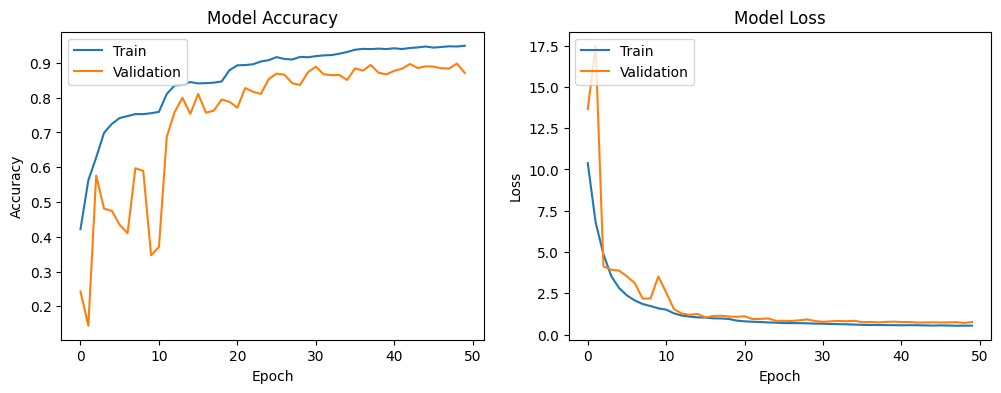

71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9479 - loss: 0.5424
✅ Final Validation Accuracy: 0.8980


In [28]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/kaggle/working/training_history.png')
plt.show()

# ✅ Final validation evaluation
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"✅ Final Validation Accuracy: {val_accuracy:.4f}")


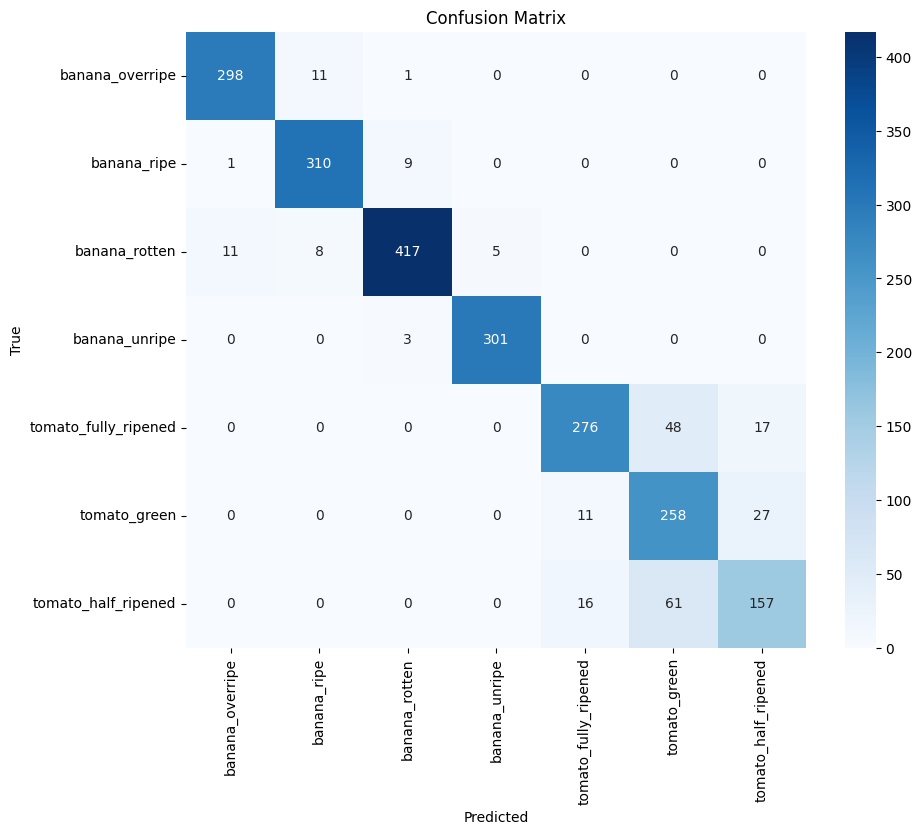

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class_names = list(val_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()


In [30]:
# Predict on test data
test_generator.reset()
test_probs = model.predict(test_generator)
test_preds = np.argmax(test_probs, axis=1)

# Create submission DataFrame
import pandas as pd
filenames = test_generator.filenames
ids = [f.split("/")[-1] for f in filenames]  # Assuming files are in one folder

df = pd.DataFrame({
    "Id": ids,
    "Category": test_preds
})
df.to_csv("/kaggle/working/submission.csv", index=False)
print("✅ Submission file saved as submission.csv")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 37s 417ms/step
✅ Submission file saved as submission.csv


In [31]:
# # Load weights if needed
# model.load_weights("/kaggle/working/resnet_weights.h5")

# test_dir = "/kaggle/input/fine-grained-fruit-quality-assessment/test/test"
# test_images = sorted(os.listdir(test_dir))

# label_map = {v: k for k, v in trainData.class_indices.items()}
# results = []

# for img_name in test_images:
#     img_path = os.path.join(test_dir, img_name)
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
#     x = tf.keras.preprocessing.image.img_to_array(img) / 255.0
#     x = np.expand_dims(x, axis=0)

#     preds = model.predict(x)
#     pred_label = label_map[np.argmax(preds)]
#     results.append({"image_id": img_name, "label": pred_label})

# df = pd.DataFrame(results)
# df.to_csv("/kaggle/working/resnet_predictions.csv", index=False)
# print("✅ Saved predictions to resnet_predictions.csv")
